In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

# import from parent level
import sys 
sys.path.append('..')
from path_parameters import TRAIN_PATH, TEST_PATH, OUTPUT_PATH

2022-04-05 09:20:32.537807: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-05 09:20:32.537839: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data_path = TRAIN_PATH
test_path = TEST_PATH
output_path = OUTPUT_PATH

### Prepare data

In [3]:
# List of dataset to use for training
train_files = ["ssp126", "ssp585", "historical", "hist-GHG"]

In [4]:
# Create training and testing arrays
X_train = pd.concat([create_predictor_data([file])[0] for file in train_files])
y_train_tas = np.vstack([create_predictdand_data([file])["tas"].values.reshape(-1, 96 * 144)
                         for file in train_files])

X_test, _ = create_predictor_data(["ssp245"], test=True)
Y_test = xr.open_dataset(test_path + "outputs_ssp245.nc").compute()
tas_truth = Y_test["tas"].mean("member")

/home/julia/anaconda3/envs/climatebench01/lib/python3.7/site-packages/eofs/standard.py:272: RuntimeWarning: invalid value encountered in true_divide
  return self._P[:, slicer] / np.sqrt(self._L[slicer])


In [5]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_tas = y_train_tas[~nan_train_mask]
assert len(X_train) == len(y_train_tas)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
tas_truth = tas_truth[~nan_test_mask]

In [6]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [7]:
# Standardize predictand fields
train_tas_mean, train_tas_std = y_train_tas.mean(), y_train_tas.std()
y_train_tas = (y_train_tas - train_tas_mean) / train_tas_std

### Prepare model

In [8]:
# Make kernel
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

2022-04-05 09:21:14.179358: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-05 09:21:14.179392: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-05 09:21:14.179409: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Rivendell): /proc/driver/nvidia/version does not exist
2022-04-05 09:21:14.179658: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Make model
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_tas.astype(np.float64)),
                          kernel=kernel,
                          mean_function=mean)

In [10]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

2022-04-05 09:21:50.960716: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78669D+06    |proj g|=  9.67251D+05


 This problem is unconstrained.



At iterate    1    f=  3.00289D+06    |proj g|=  2.70259D+05

At iterate    2    f=  2.78168D+06    |proj g|=  4.72897D+05

At iterate    3    f=  2.14325D+06    |proj g|=  2.41913D+05

At iterate    4    f=  1.82263D+06    |proj g|=  2.49466D+05

At iterate    5    f=  1.77628D+06    |proj g|=  2.85494D+04

At iterate    6    f=  1.76410D+06    |proj g|=  3.75357D+04

At iterate    7    f=  1.74407D+06    |proj g|=  1.43271D+04

At iterate    8    f=  1.72949D+06    |proj g|=  1.63253D+04

At iterate    9    f=  1.71725D+06    |proj g|=  8.36312D+03

At iterate   10    f=  1.70640D+06    |proj g|=  2.55238D+04

At iterate   11    f=  1.70408D+06    |proj g|=  3.07051D+03

At iterate   12    f=  1.70293D+06    |proj g|=  1.20869D+04

At iterate   13    f=  1.70220D+06    |proj g|=  7.83861D+03

At iterate   14    f=  1.70100D+06    |proj g|=  2.60050D+03

At iterate   15    f=  1.69983D+06    |proj g|=  3.46588D+03

At iterate   16    f=  1.69975D+06    |proj g|=  1.88847D+04

At iter


At iterate  134    f=  1.66407D+06    |proj g|=  3.62000D+02

At iterate  135    f=  1.66407D+06    |proj g|=  2.12533D+02

At iterate  136    f=  1.66407D+06    |proj g|=  3.04379D+02

At iterate  137    f=  1.66407D+06    |proj g|=  2.39887D+02

At iterate  138    f=  1.66407D+06    |proj g|=  7.25506D+01

At iterate  139    f=  1.66407D+06    |proj g|=  5.72030D+01

At iterate  140    f=  1.66407D+06    |proj g|=  3.78207D+02

At iterate  141    f=  1.66406D+06    |proj g|=  2.20107D+02

At iterate  142    f=  1.66406D+06    |proj g|=  4.06046D+01

At iterate  143    f=  1.66406D+06    |proj g|=  8.18478D+01

At iterate  144    f=  1.66406D+06    |proj g|=  1.55616D+02

At iterate  145    f=  1.66406D+06    |proj g|=  5.11946D+01

At iterate  146    f=  1.66406D+06    |proj g|=  4.45047D+01

At iterate  147    f=  1.66406D+06    |proj g|=  4.79102D+01

At iterate  148    f=  1.66406D+06    |proj g|=  1.25529D+02

At iterate  149    f=  1.66406D+06    |proj g|=  2.03349D+01

At iter

      fun: 1664063.7882366495
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.34152551,  0.46561029,  0.9229575 , -4.30240677, -3.01763974,
        5.80863957, -5.24885592, -1.2129882 ,  0.1497421 , -0.7860434 ,
        0.20337521, -0.61032784, -1.64647485,  5.2065654 , -1.26934224,
        0.60797419, 22.40846479,  4.6935199 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 185
      nit: 156
     njev: 185
   status: 0
  success: True
        x: array([ 7.64140967,  7.20649463,  0.09347043, -4.11626114, -3.22646405,
       -1.41160787, -1.67689826, 10.60464978, 22.76626614, -3.25789631,
        6.49619688, 91.3624034 , 81.49941799, 53.97420857, 70.81567551,
       -1.84449505, -2.52970459,  0.55492896])


At iterate  156    f=  1.66406D+06    |proj g|=  2.24085D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18    156    185      1     0     0   2.241D+01   1.664D+06
  F =   1664063.7882366495     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


### Predict on testing set

In [11]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_tas_std + train_tas_mean
posterior_std = np.sqrt(standard_posterior_var) * train_tas_std

In [12]:
# put output back into xarray format for calculating RMSE/plotting
posterior_tas = np.reshape(posterior_mean, [86, 96, 144])
posterior_tas_std = np.reshape(posterior_std, [86, 96, 144])

posterior_tas_data = xr.DataArray(posterior_tas, dims=tas_truth.dims, coords=tas_truth.coords)
posterior_tas_std_data = xr.DataArray(posterior_tas_std, dims=tas_truth.dims, coords=tas_truth.coords)

In [13]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(tas_truth[35], posterior_tas_data[35])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[85], posterior_tas_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[30:41], posterior_tas_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[75:], posterior_tas_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[35:], posterior_tas_data[35:]).mean()}")

RMSE at 2050: 0.31237361635637295
RMSE at 2100: 0.32167284262508217
RMSE 2045-2055: 0.3658429933408657
RMSE 2090-2100: 0.36123206883818554
RMSE 2050-2100: 0.36172115360298335


[Text(0.5, 1.0, 'Difference')]

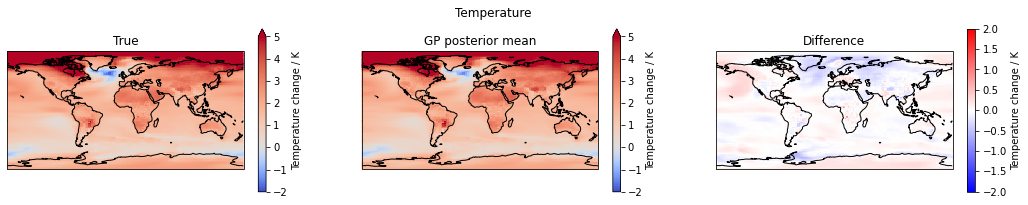

In [14]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
tas_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_tas_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = tas_truth - posterior_tas_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

__Feature importance__
- Mostly CO2
- Really just CO2
- Small noise variance

In [15]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.55492896]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,7.207236104933716
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,7.641889708032819
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.01617385919660719
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.7409740857955971
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.03774774470954029
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[0.03892992, 0.21813185, 0.17138948..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.14678516598331562
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[6.49770491, 91.3624034, 81.49941799..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.07666806829119041


In [16]:
# Save predictions
posterior_tas_data.to_netcdf(output_path + "climatebench-gp-posterior-mean-tas-test-2019-2100.nc")
posterior_tas_std_data.to_netcdf(output_path + "climatebench-gp-posterior-std-tas-test-2019-2100.nc")